# Example of Forecasting a Time Series using a Tree-Based Model
 

In [1]:
import sys, re, time, math
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.seasonal import STL
from scipy.signal import savgol_filter
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import HistGradientBoostingRegressor
import matplotlib
import sklearn 
import matplotlib.pyplot as plt

In [2]:
print('python',sys.version.split()[0])
print('np',np.__version__)
print('pd',pd.__version__)
print('matplotlib',matplotlib.__version__)
print('sklearn',sklearn.__version__)

python 3.9.12
np 1.23.1
pd 1.4.3
matplotlib 3.5.2
sklearn 1.1.1


# Simulated Data Set


In [3]:
df = pd.DataFrame()
df["dt"] = pd.date_range("2015-01-01", "2021-12-31", freq = "D")
df.head()

,dt
0,2015-01-01
1,2015-01-02
2,2015-01-03
3,2015-01-04
4,2015-01-05


## Cyclic Calendar Features


In [4]:
df["dw"] = df["dt"].dt.dayofweek+1
df["dm"] = df["dt"].dt.day
df["dy"] = df["dt"].dt.dayofyear
df["dn"] = df.index+1
df["yr"] = df["dt"].dt.year
df.head()

,dt,dw,dm,dy,dn,yr
0,2015-01-01,4,1,1,1,2015
1,2015-01-02,5,2,2,2,2015
2,2015-01-03,6,3,3,3,2015
3,2015-01-04,7,4,4,4,2015
4,2015-01-05,1,5,5,5,2015


## Convert Cyclic Calendar Features to Trigonometric Features


In [5]:
df["sdw"] = np.sin(2.0 * np.pi * (df["dw"] - 1) / 7)
df["cdw"] = np.cos(2.0 * np.pi * (df["dw"] - 1) / 7)
df["sdm"] = np.sin(2.0 * np.pi * (df["dm"] - 1) / df["dt"].dt.days_in_month)
df["cdm"] = np.cos(2.0 * np.pi * (df["dm"] - 1) / df["dt"].dt.days_in_month)
df["sdy"] = np.sin(2.0 * np.pi * (df["dy"] - 1) / 366)
df["cdy"] = np.cos(2.0 * np.pi * (df["dy"] - 1) / 366)
df.head()


,dt,dw,dm,dy,dn,yr,sdw,cdw,sdm,cdm,sdy,cdy
0,2015-01-01,4,1,1,1,2015,0.433884,-0.900969,0.000000,1.000000,0.000000,1.000000
1,2015-01-02,5,2,2,2,2015,-0.433884,-0.900969,0.201299,0.979530,0.017166,0.999853
2,2015-01-03,6,3,3,3,2015,-0.974928,-0.222521,0.394356,0.918958,0.034328,0.999411
3,2015-01-04,7,4,4,4,2015,-0.781831,0.623490,0.571268,0.820763,0.051479,0.998674
4,2015-01-05,1,5,5,5,2015,0.000000,1.000000,0.724793,0.688967,0.068615,0.997643


## Holidays

In [6]:
cal = calendar()
holidays = cal.holidays(start = df["dt"].min(), end = df["dt"].max())
df["hd"] = df["dt"].isin(holidays).astype(int)           # Federal Holiday
df["bh"] = df["hd"].shift(periods = -1, fill_value = 0)  # Day Before Holiday
df["ah"] = df["hd"].shift(periods = +1, fill_value = 0)  # Day After Holiday
df.head(10)

,dt,dw,dm,dy,dn,yr,sdw,cdw,sdm,cdm,sdy,cdy,hd,bh,ah
0,2015-01-01,4,1,1,1,2015,0.433884,-0.900969,0.000000,1.000000,0.000000,1.000000,1,0,0
1,2015-01-02,5,2,2,2,2015,-0.433884,-0.900969,0.201299,0.979530,0.017166,0.999853,0,0,1
2,2015-01-03,6,3,3,3,2015,-0.974928,-0.222521,0.394356,0.918958,0.034328,0.999411,0,0,0
3,2015-01-04,7,4,4,4,2015,-0.781831,0.623490,0.571268,0.820763,0.051479,0.998674,0,0,0
4,2015-01-05,1,5,5,5,2015,0.000000,1.000000,0.724793,0.688967,0.068615,0.997643,0,0,0
5,2015-01-06,2,6,6,6,2015,0.781831,0.623490,0.848644,0.528964,0.085731,0.996318,0,0,0
6,2015-01-07,3,7,7,7,2015,0.974928,-0.222521,0.937752,0.347305,0.102821,0.994700,0,0,0
7,2015-01-08,4,8,8,8,2015,0.433884,-0.900969,0.988468,0.151428,0.119881,0.992788,0,0,0
8,2015-01-09,5,9,9,9,2015,-0.433884,-0.900969,0.998717,-0.050649,0.136906,0.990584,0,0,0
9,2015-01-10,6,10,10,10,2015,-0.974928,-0.222521,0.968077,-0.250653,0.153891,0.988088,0,0,0


## Noise and Trend

Noise = random normal (0, 1) variable for each date.

Trend = step changes (randomly up or down) smoothed by savgol filter.

In [7]:
# Noise for each date
df["noise"] = np.random.normal(0, 1.0, len(df))
# Step changes randomly dispersed throughout the time series
chngpts = sorted(np.random.choice(df["dn"], size=50, replace=False))
df["change"] = np.where(df["dn"].isin(chngpts), 1, 0)
df["step"] = np.random.choice([-1,1], size=len(df), p=[0.5,0.5]) * df["change"]
df["step"] = df["step"].cumsum()
# Smooth step changes (i.e. non-linear trend)
df["trend"] = savgol_filter(df["step"].values, window_length=99, polyorder=1)
df.head()

,dt,dw,dm,dy,dn,yr,sdw,cdw,sdm,cdm,sdy,cdy,hd,bh,ah,noise,change,step,trend
0,2015-01-01,4,1,1,1,2015,0.433884,-0.900969,0.000000,1.000000,0.000000,1.000000,1,0,0,0.176513,0,0,0.0
1,2015-01-02,5,2,2,2,2015,-0.433884,-0.900969,0.201299,0.979530,0.017166,0.999853,0,0,1,-1.937535,0,0,0.0
2,2015-01-03,6,3,3,3,2015,-0.974928,-0.222521,0.394356,0.918958,0.034328,0.999411,0,0,0,-1.661896,0,0,0.0
3,2015-01-04,7,4,4,4,2015,-0.781831,0.623490,0.571268,0.820763,0.051479,0.998674,0,0,0,0.699665,0,0,0.0
4,2015-01-05,1,5,5,5,2015,0.000000,1.000000,0.724793,0.688967,0.068615,0.997643,0,0,0,0.788798,0,0,0.0


## Target Variable

Construct the target variable from various components.

In [8]:
df["y"] = 100 
df["y"] = df["y"] + df["trend"] + df["noise"]
df["y"] = df["y"] + (df["sdw"] + df["cdw"])
df["y"] = df["y"] + (df["sdm"] + df["cdm"])
df["y"] = df["y"] + (df["sdy"] + df["cdy"])
df["y"] = df["y"] + (2 * df["hd"])
df["y"] = df["y"] + (-2 * df["bh"])
df["y"] = df["y"] + (-2 * df["ah"])
df.head()

,dt,dw,dm,dy,dn,yr,sdw,cdw,sdm,cdm,sdy,cdy,hd,bh,ah,noise,change,step,trend,y
0,2015-01-01,4,1,1,1,2015,0.433884,-0.900969,0.000000,1.000000,0.000000,1.000000,1,0,0,0.176513,0,0,0.0,103.709427
1,2015-01-02,5,2,2,2,2015,-0.433884,-0.900969,0.201299,0.979530,0.017166,0.999853,0,0,1,-1.937535,0,0,0.0,96.925460
2,2015-01-03,6,3,3,3,2015,-0.974928,-0.222521,0.394356,0.918958,0.034328,0.999411,0,0,0,-1.661896,0,0,0.0,99.487707
3,2015-01-04,7,4,4,4,2015,-0.781831,0.623490,0.571268,0.820763,0.051479,0.998674,0,0,0,0.699665,0,0,0.0,102.983508
4,2015-01-05,1,5,5,5,2015,0.000000,1.000000,0.724793,0.688967,0.068615,0.997643,0,0,0,0.788798,0,0,0.0,104.268816


# Plot

Plot the target variable.

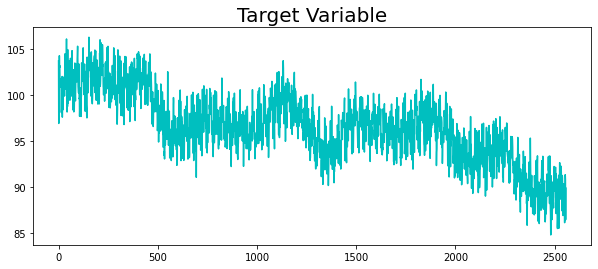

In [9]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(df.index, df.y,color="c")
ax.set_title(f"Target Variable", fontsize= 20)
plt.show()

## Features

**NOTE:** we aren't using the trig features since those were used to create the target variable. In a real-world example, we could use these along with other calendar features.

In [10]:
x_vars = ["hd","bh","ah","dw","dm","dy","dn","yr"]
print("Features =", x_vars)

Features = ['hd', 'bh', 'ah', 'dw', 'dm', 'dy', 'dn', 'yr']


## Time Series Split

Create time series splits. These are used to evaluate forecast accuracy.

- n_splits: the number of time series splits (similar to k in k-fold cross-validation)
- test_size: the number of observations in the test split (i.e. forecast horizon)
- max_train_size: the maximum number of observations in the train split
- gap: how much gap (measured in number of time steps) between splits

In [11]:
n_splits = 4
test_size = 365
ts_split = TimeSeriesSplit(n_splits=n_splits, test_size=test_size, gap=0)
all_splits = list(ts_split.split(df))
ts_split

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=365)

## Function to convert seconds to hours minutes seconds

Used for timing of various operations.

In [12]:
def sec_to_hms(secs):
    m, s = divmod(secs, 60)
    h, m = divmod(m, 60)
    h_str = "%d"   % int(h)
    m_str = "%02d" % int(m)
    s_str = "%02.2f" % round(s,2)
    s_str = re.sub(r'\.00$','',s_str)
    return ':'.join([h_str,m_str,s_str])

## Trend: Fit and Forecast

Fit a trend to the training split, then forecast (predict) the trend for the test split.

In [13]:
n_trend = 725
n_lags = 61
df_trend_results = pd.DataFrame()
# Loop Thru The Splits
for split in np.arange(0, n_splits):
    t1 = time.time()
    train_index, test_index = all_splits[split]
    endog_train = df.loc[train_index,["dt","y"]].set_index("dt").squeeze().asfreq("D") # Training Split (Past) to Extract STL Decomp
    stl = STL(endog=endog_train, period=7, trend=n_trend).fit() # STL Decomp
    df_trend_act = pd.DataFrame({"trend": endog_train}) # Actuals for Training Split
    df_trend_act["split"] = split
    df_trend_act["type"] = "actual"
    df_trend_act = df_trend_act.reset_index().rename(columns={"index":"dt"})
    df_trend_fit = pd.DataFrame(stl.trend) # Fitted Trend for Training Split
    df_trend_fit["split"] = split
    df_trend_fit["type"] = "fitted"
    df_trend_fit = df_trend_fit.reset_index()
    trend_mod = AutoReg(endog=stl.trend, lags=n_lags, seasonal=False).fit() # Model the Trend
    trend_fore = trend_mod.forecast(steps=test_index.shape[0]) # Testing Split (Future) for Trend Forecast
    df_trend_fore = pd.DataFrame({"trend": trend_fore})
    df_trend_fore["split"] = split
    df_trend_fore["type"] = "forecast"
    df_trend_fore = df_trend_fore.reset_index().rename(columns={"index":"dt"}).set_index(test_index)
    df_trend_results = pd.concat([df_trend_results, df_trend_act, df_trend_fit, df_trend_fore]) # Combine Trend Fit and Forecast for each Split
    seconds = time.time() - t1
    print("De-trending time for split " + split.astype("str") + ": " + sec_to_hms(seconds))

De-trending time for split 0: 0:00:0.29
De-trending time for split 1: 0:00:0.33
De-trending time for split 2: 0:00:0.40
De-trending time for split 3: 0:00:0.48


## Plot the Trend

Plot the trend, both fit to past and forecast in future, for each time series split.

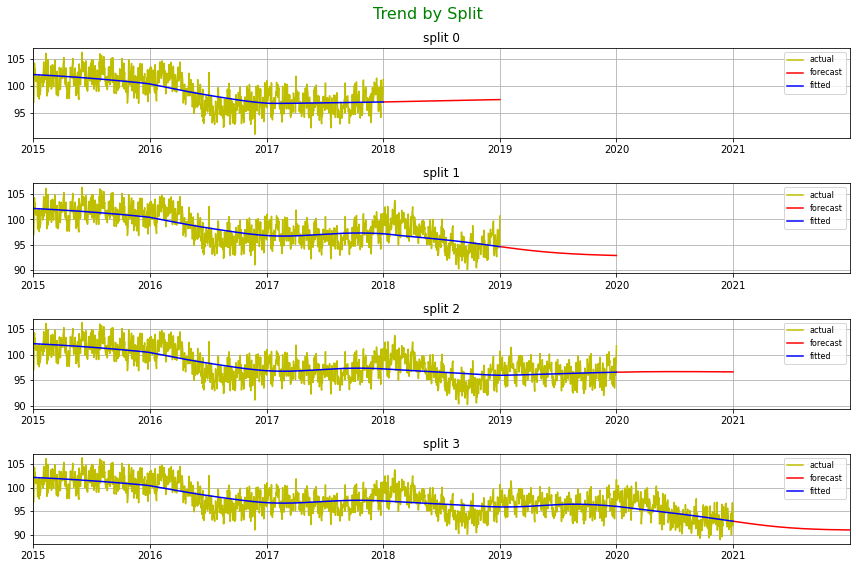

In [14]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(12,8))
date1 = df_trend_results.dt.min()
date2 = df_trend_results.dt.max()
for ii in range(len(ax)):
    _ = ax[ii].set_title(f"split {ii}")
    _ = ax[ii].grid(True)
    _ = ax[ii].set_xlim(date1,date2)
    mask = df_trend_results.split==ii
    dft = df_trend_results[mask].copy()
    mask = dft.type=="actual"
    dfta = dft[mask].copy()
    mask = dft.type=="forecast"
    dftf = dft[mask].copy()
    mask = dft.type=="fitted"
    dftfit = dft[mask].copy()
    _ = ax[ii].plot(dfta.dt, dfta.trend, color='y', label = "actual")
    _ = ax[ii].plot(dftf.dt, dftf.trend, color='red',label = "forecast")
    _ = ax[ii].plot(dftfit.dt, dftfit.trend, color='blue', label = "fitted")
    _ = ax[ii].legend(fontsize=8)
fig.suptitle('Trend by Split', fontsize=16, color='g')
fig.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.5)
plt.show() ;

## De-Trend the Time Series

De-trend the time series so that we can train the tree-based model on the data without needing to worry if the forecast horizon will extrapolate outside the range of values seen in the training data.

In [15]:
df_detrend_results = pd.DataFrame()
for split in np.arange(0, n_splits):
    t1 = time.time()
    train_index, test_index = all_splits[split]
    x_train = np.ravel(df.loc[train_index, ["dt"]])
    y_train = np.ravel(df.loc[train_index, ["y"]])
    y_trend = np.ravel(df_trend_results.query("split==@split and type=='fitted'")["trend"])
    df_detrend = pd.DataFrame({"dt": x_train, "detrend": y_train - y_trend, "split": split})
    df_detrend_results = pd.concat([df_detrend_results, df_detrend])
    seconds = time.time() - t1
    print("Detrending for split ", str(split), ":", sec_to_hms(seconds))

Detrending for split  0 : 0:00:0.01
Detrending for split  1 : 0:00:0
Detrending for split  2 : 0:00:0
Detrending for split  3 : 0:00:0


## Plot the Detrended Time Series

Note that cyclic patterns still exist.

In [16]:
df_trend_results

,dt,trend,split,type
0,2015-01-01,103.709427,0,actual
1,2015-01-02,96.925460,0,actual
2,2015-01-03,99.487707,0,actual
3,2015-01-04,102.983508,0,actual
4,2015-01-05,104.268816,0,actual
...,...,...,...,...
2552,2021-12-27,91.100114,3,forecast
2553,2021-12-28,91.099459,3,forecast
2554,2021-12-29,91.098814,3,forecast
2555,2021-12-30,91.098179,3,forecast


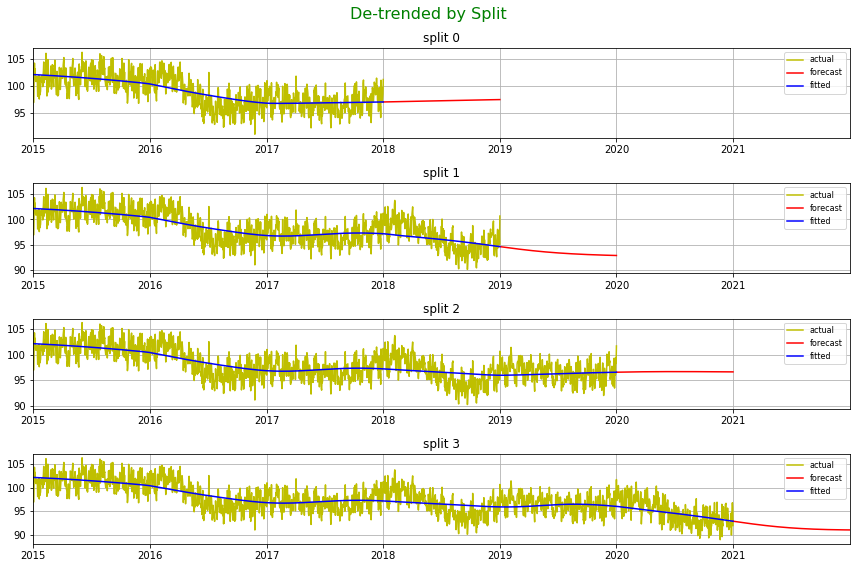

In [17]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(12,8))
date1 = df_trend_results.dt.min()
date2 = df_trend_results.dt.max()
for ii in range(len(ax)):
    _ = ax[ii].set_title(f"split {ii}")
    _ = ax[ii].grid(True)
    _ = ax[ii].set_xlim(date1,date2)
    mask = df_trend_results.split==ii
    dft = df_trend_results[mask].copy()
    mask = dft.type=="actual"
    dfta = dft[mask].copy()
    mask = dft.type=="forecast"
    dftf = dft[mask].copy()
    mask = dft.type=="fitted"
    dftfit = dft[mask].copy()
    _ = ax[ii].plot(dfta.dt, dfta.trend, color='y', label = "actual")
    _ = ax[ii].plot(dftf.dt, dftf.trend, color='red',label = "forecast")
    _ = ax[ii].plot(dftfit.dt, dftfit.trend, color='blue', label = "fitted")
    _ = ax[ii].legend(fontsize=8)
fig.suptitle('De-trended by Split', fontsize=16, color='g')
fig.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.5)
plt.show() ;

## Fit a Tree-Based Model

Train a tree-based model on the de-trended time series. 

In [18]:
# Training by split
# takes approx 1 minute
df_tree_pred = pd.DataFrame()
for split in np.arange(0, n_splits):
    t1 = time.time()
    tree_mod = HistGradientBoostingRegressor(max_iter=300, max_depth=30, learning_rate=0.1, l2_regularization=0.1) # Model Spec
    train_index, test_index = all_splits[split] # Train/Test Splits for X and Y
    x_train = df.loc[train_index, x_vars]
    x_test = df.loc[test_index, x_vars]
    y_train = np.ravel(df_detrend_results.query("split==@split")["detrend"])
    df_tree_train_split = df.loc[train_index,["dt"]]
    df_tree_train_split["trend"] = np.ravel(df_trend_results.query("split==@split and type=='fitted'")["trend"])
    df_tree_train_split["y"] = y_train
    df_tree_train_split["split"] = split
    df_tree_train_split["type"] = "actual"
    tree_mod.fit(X = x_train, y = y_train) # Fit Model
    df_tree_pred_split = df.loc[test_index,["dt"]] # Make Predictions
    df_tree_pred_split["trend"] = np.ravel(df_trend_results.query("split==@split and type=='forecast'")["trend"])
    df_tree_pred_split["y"] = tree_mod.predict(X=x_test)
    df_tree_pred_split["split"] = split
    df_tree_pred_split["type"] = "forecast"
    df_tree_pred = pd.concat([df_tree_pred, df_tree_train_split, df_tree_pred_split]) # Collect Results
    seconds = time.time() - t1
    print("Training time for split:", split.astype("str"), "=", sec_to_hms(seconds))

Training time for split: 0 = 0:00:9.10
Training time for split: 1 = 0:00:11.42
Training time for split: 2 = 0:00:11.51
Training time for split: 3 = 0:00:9.67


### Plot the tree-model forecasts/predictions.

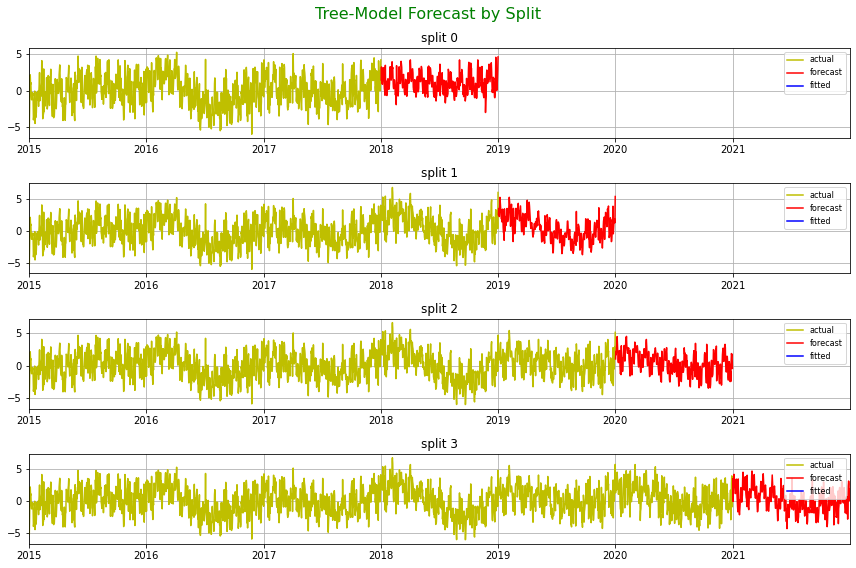

In [19]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(12,8))
date1 = df_tree_pred.dt.min()
date2 = df_tree_pred.dt.max()
for ii in range(len(ax)):
    _ = ax[ii].set_title(f"split {ii}")
    _ = ax[ii].grid(True)
    _ = ax[ii].set_xlim(date1,date2)
    mask = df_tree_pred.split==ii
    dft = df_tree_pred[mask].copy()
    mask = dft.type=="actual"
    dfta = dft[mask].copy()
    mask = dft.type=="forecast"
    dftf = dft[mask].copy()
    mask = dft.type=="fitted"
    dftfit = dft[mask].copy()
    _ = ax[ii].plot(dfta.dt, dfta.y, color='y', label = "actual")
    _ = ax[ii].plot(dftf.dt, dftf.y, color='red',label = "forecast")
    _ = ax[ii].plot(dftfit.dt, dftfit.y, color='blue', label = "fitted")
    _ = ax[ii].legend(fontsize=8)
fig.suptitle('Tree-Model Forecast by Split', fontsize=16, color='g')
fig.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.5)
plt.show() ;

## Combine Forecasts

Combine the trend forecast and the tree-model forecast for each split.

In [20]:
df_forecast_all = df_tree_pred.copy()
df_forecast_all["combined"] = df_forecast_all["trend"] + df_forecast_all["y"]
df_forecast_all

,dt,trend,y,split,type,combined
0,2015-01-01,102.147546,1.561881,0,actual,103.709427
1,2015-01-02,102.144512,-5.219052,0,actual,96.925460
2,2015-01-03,102.141470,-2.653764,0,actual,99.487707
3,2015-01-04,102.138420,0.845088,0,actual,102.983508
4,2015-01-05,102.135362,2.133454,0,actual,104.268816
...,...,...,...,...,...,...
2552,2021-12-27,91.100114,2.298354,3,forecast,93.398468
2553,2021-12-28,91.099459,3.055008,3,forecast,94.154466
2554,2021-12-29,91.098814,2.577751,3,forecast,93.676565
2555,2021-12-30,91.098179,-0.002580,3,forecast,91.095599


### Plot the forecasts

In [21]:
# fig, ax = plt.subplots(figsize=(10,4))
# ax.plot(df_forecast_all.dt, df_forecast_all.combined ,color="blue")
# ax.set_title(f" Tree-Model + Trend Forecast by Split ", fontsize= 20)
# plt.xlabel('Date', fontsize=20)
# plt.ylabel('Target', fontsize=20)
# plt.show()

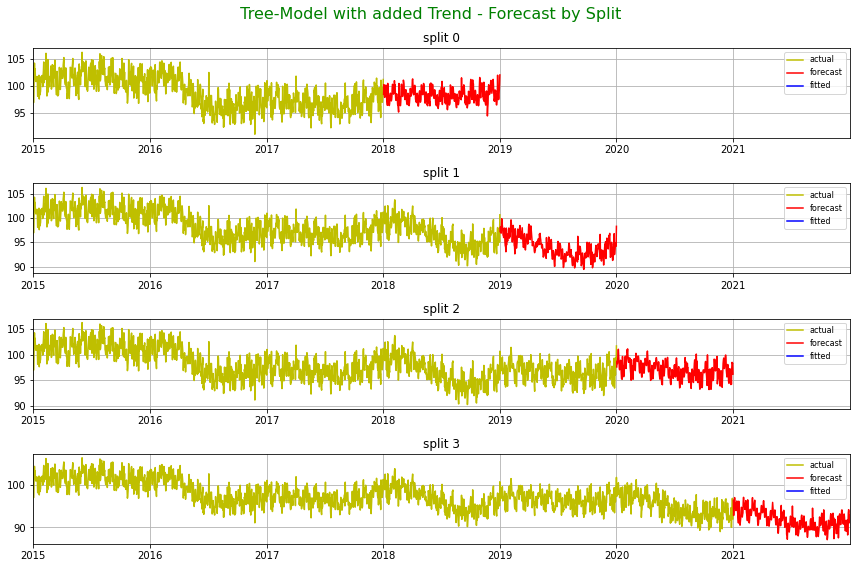

In [22]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(12,8))
date1 = df_forecast_all.dt.min()
date2 = df_forecast_all.dt.max()
for ii in range(len(ax)):
    _ = ax[ii].set_title(f"split {ii}")
    _ = ax[ii].grid(True)
    _ = ax[ii].set_xlim(date1,date2)
    mask = df_forecast_all.split==ii
    dft = df_forecast_all[mask].copy()
    mask = dft.type=="actual"
    dfta = dft[mask].copy()
    mask = dft.type=="forecast"
    dftf = dft[mask].copy()
    mask = dft.type=="fitted"
    dftfit = dft[mask].copy()
    _ = ax[ii].plot(dfta.dt, dfta.combined, color='y', label = "actual")
    _ = ax[ii].plot(dftf.dt, dftf.combined, color='red',label = "forecast")
    _ = ax[ii].plot(dftfit.dt, dftfit.combined, color='blue', label = "fitted")
    _ = ax[ii].legend(fontsize=8)
fig.suptitle(f" Tree-Model with added Trend - Forecast by Split", fontsize=16, color='g')
fig.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.5)
plt.show() ;

## Compare Forecast Error 

Use Lev's custom error function to calculate the forecast error.

See this [repo](https://github.com/lselector/statistics/blob/master/nb_Time_Series_Forecast_Error.ipynb) for more details.

In [23]:
from sklearn.metrics import mean_squared_error
# Function from Lev's Repo
def fin_err(actual, 
            predicted, 
            norm=None,
            err_type='mae',   # mae or rmse
            noise_level_relative=1e-2,
            noise_level_absolute=1e-2,
            max_error=1e2):
    """
    # calculate relative difference 
    # between two arrays (or lists): actual & predicted
    # fin_err() is similar to normalized_mean_absolute_error
    # but optimized for financial data.
    # It takes into account not only amplitude of oscillations,
    # but also the "level" of values.
    # It also limits maximum error in cases when 
    # actual signal doesn't change much
    # optional parameters:
    #   norm (when provided) used as denominator
    #   noise_level_relative (default 0.01)
    #   noise_level_absolute (default 0.01)
    #   max_error (default 100.0)
    """
    Na, Np = len(actual), len(predicted)
    if Na == 0 or Np == 0 or Na != Np:
        return np.nan
    np_act = np.array(actual, dtype = np.float64)
    np_pre = np.array(predicted, dtype = np.float64)
    if err_type == 'mae': # Mean Absolute Error
        myerr = np.abs(np_act - np_pre).sum() / Na
    elif err_type == 'rmse': # Root Mean Square Error
        myerr = math.sqrt(mean_squared_error(np_act, np_pre)) 
    else:
        print("ERROR: err_type should be 'mae' or 'rmse', exiting ...")
        sys.exit(1)
    if norm and norm > 0: # normalize - and limit
        return min (max_error, myerr / norm )  
    v_max_act, v_min_act = np.max(np_act), np.min(np_act) # max min   
    v_max_pre, v_min_pre = np.max(np_pre), np.min(np_pre) # max min  
    v_amp_act   = v_max_act - v_min_act        # amplitude      
    v_amp_pre   = v_max_pre - v_min_pre        # amplitude      
    v_level_act = np.abs(np_act).sum() / Na    # level             
    v_scale_act = max(v_level_act, v_amp_act)  # level
    v_level_pre = np.abs(np_pre).sum() / Na    # scale             
    v_scale_pre = max(v_level_pre, v_amp_pre)  # scale
    if (v_scale_act <= noise_level_absolute and 
        v_scale_pre <= noise_level_absolute):
            return 0 # actual and predicted are both close to zero 
    denom_min = max(v_scale_act * noise_level_relative,
                    noise_level_absolute)
    if v_scale_act > denom_min :
        denom = v_scale_act
    else:
        denom = denom_min
    return min (max_error, (myerr / denom))

In [24]:
for split in np.arange(0, n_splits):
    train_index, test_index = all_splits[split]
    y_pred_tree = np.ravel(df_forecast_all.query("split==@split and type=='forecast'").loc[:,["combined"]])
    y_actual = np.ravel(df.loc[test_index, ["y"]])
    # Calculate Error Stats
    tree_error = fin_err(actual=y_actual, predicted=y_pred_tree, err_type="rmse")
    # Print Error Stats
    print("-"*40)
    print("Errors for Split " + str(split) + ":")
    print("Tree-Based Model " + f"= {np.round(100*tree_error, 2)}" + "%")


----------------------------------------
Errors for Split 0:
Tree-Based Model = 3.12%
----------------------------------------
Errors for Split 1:
Tree-Based Model = 3.03%
----------------------------------------
Errors for Split 2:
Tree-Based Model = 2.75%
----------------------------------------
Errors for Split 3:
Tree-Based Model = 1.65%


In [25]:
y_actual = np.ravel(df.tail(test_size*n_splits)["y"])
y_pred_tree = np.ravel(df_forecast_all.query("type=='forecast'").loc[:,["combined"]])
# Tree-Based Model
tree_error = fin_err(actual=y_actual, predicted=y_pred_tree, err_type='rmse')
# Print Error Metrics
print(f"Tree-Based Model = {np.round(100*tree_error, 2)}" + "%")

Tree-Based Model = 2.73%


# Forecasts zoomed in

In [26]:
# concat vertically 1 year of actual data and 1 year of forecast
df_plot = pd.concat([
    df.query("dt>='2019-01-02' and dt<='2020-01-01'")
            .loc[:,["dt","y"]]
            .assign(type="actual"),
    df_forecast_all.query("split==1 & type=='forecast'")
            .loc[:,["dt","combined"]].rename(columns={"combined":"y"})
            .assign(type="tree"),
])

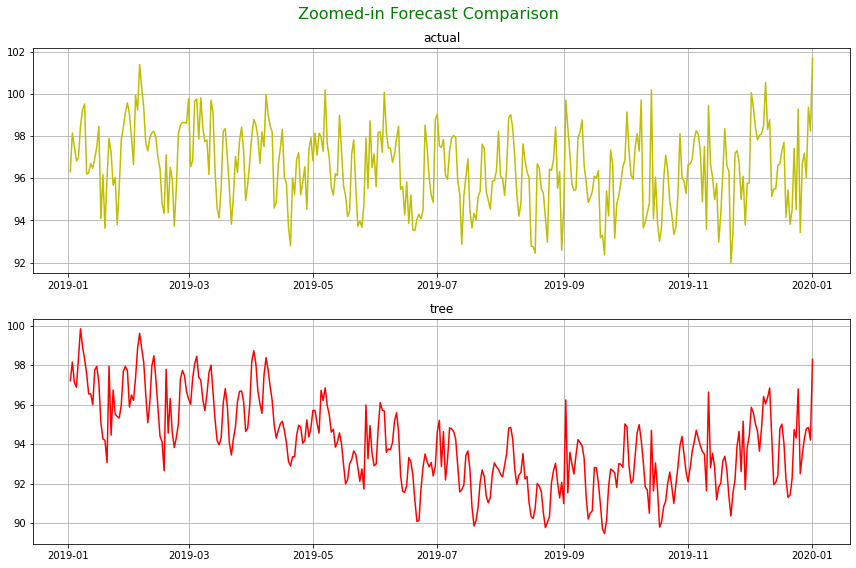

In [27]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
date1 = df_plot.dt.min()
date2 = df_plot.dt.max()
mytype_list = ["actual","tree"]
mycolor_list = ["y","r"]

for ii in range(len(ax)):
    type_label = mytype_list[ii]
    mycolor = mycolor_list[ii]
    _ = ax[ii].set_title(type_label)
    _ = ax[ii].grid(True)
    mask = df_plot.type == mytype_list[ii]
    dft = df_plot[mask].copy()
    _ = ax[ii].plot(dft.dt, dft.y, color=mycolor, label=type_label)
fig.suptitle(f"Zoomed-in Forecast Comparison", fontsize=16, color='g')
fig.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show() ;